In [2]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import apexpy as ap
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d
import os
import glob
import sys
import h5py
path = os.getcwd()
if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
    path_m =  '/Home/siv30/wad005/master/GRB/MATLAB/david_sarria/'
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb
    path_m = '/Users/andreas/phys/master/GRB/MATLAB/david_sarria/'


all UiB paths loaded


In [76]:
def get_mlat(lat=None,lon=None,alt=None,date_string=None):
    date_time = datetime.fromisoformat(date_string)
    A = ap.Apex(date=date_time)
    # geo to MLT
    mlat, mlt = A.convert(lat, lon, 'geo', 'mlt', datetime=date_time, height=alt)
    return mlat

In [75]:
matlabData = scipy.io.loadmat(path_m + 'ten_orbit_countrate.mat')

lat = []
lon = []
alt = []
cr = []
time = []

# Loop through the variables in the matlabData variable
for i in range(1, 16):
    # Extract the data for each variable and append it to the appropriate list
    lat.append(matlabData['lat_' + str(i)])
    lon.append(matlabData['lon_' + str(i)])
    alt.append(matlabData['alt_' + str(i)])
    cr.append(matlabData['cr_' + str(i)])
    time.append(matlabData['t_str_' + str(i)])
    
lat_data = np.concatenate(lat, axis=0).flatten()
lon_data = np.concatenate(lon, axis=0).flatten()
alt_data = np.concatenate(alt, axis=0).flatten()
cr_data = np.concatenate(cr,axis=0).flatten()
time_data = np.concatenate(time, axis=0).flatten()

print(lat_data.shape,lon_data.shape,alt_data.shape,cr_data.shape,time_data.shape)

(1798,) (1798,) (1798,) (1798,) (1798,)


In [74]:
df = pd.DataFrame({'lat':lat_data,
                  'lon':lon_data,
                  'alt':alt_data,
                  'mlat':np.zeros(len(alt_data)),
                   'cr':cr_data,
                  'time':time_data})
df

,lat,lon,alt,mlat,cr,time
0,-20.044801,-19.990256,414.445928,0.0,0,2019-03-05T00:00:03
1,-18.580684,-18.764718,413.891785,0.0,0,2019-03-05T00:00:33
2,-17.106620,-17.561906,413.352160,0.0,0,2019-03-05T00:01:03
3,-15.624052,-16.380066,412.827801,0.0,0,2019-03-05T00:01:33
4,-14.133881,-15.217097,412.321202,0.0,0,2019-03-05T00:02:03
...,...,...,...,...,...,...
1793,-30.917363,-23.072602,419.999017,0.0,0,2019-03-05T14:57:36
1794,-32.246713,-21.542500,420.575530,0.0,0,2019-03-05T14:58:06
1795,-33.553648,-19.963782,421.147314,0.0,0,2019-03-05T14:58:36
1796,-34.836248,-18.333463,421.712310,0.0,0,2019-03-05T14:59:06


In [77]:
#converting the cordinates to magnetic latitude

mlat_series = df.apply(lambda row: get_mlat(lat=row['lat'], lon=row['lon'], alt=row['alt'], date_string=row['time']), axis=1)

# Use the assign method to add the mlat_series as a new column to the DataFrame
df = df.assign(mlat=mlat_series)

In [78]:
df

,lat,lon,alt,mlat,cr,time
0,-20.044801,-19.990256,414.445928,-30.730597,0,2019-03-05T00:00:03
1,-18.580684,-18.764718,413.891785,-30.049269,0,2019-03-05T00:00:33
2,-17.106620,-17.561906,413.352160,-29.318888,0,2019-03-05T00:01:03
3,-15.624052,-16.380066,412.827801,-28.540451,0,2019-03-05T00:01:33
4,-14.133881,-15.217097,412.321202,-27.715559,0,2019-03-05T00:02:03
...,...,...,...,...,...,...
1793,-30.917363,-23.072602,419.999017,-36.616268,0,2019-03-05T14:57:36
1794,-32.246713,-21.542500,420.575530,-37.783016,0,2019-03-05T14:58:06
1795,-33.553648,-19.963782,421.147314,-38.920181,0,2019-03-05T14:58:36
1796,-34.836248,-18.333463,421.712310,-40.026508,0,2019-03-05T14:59:06


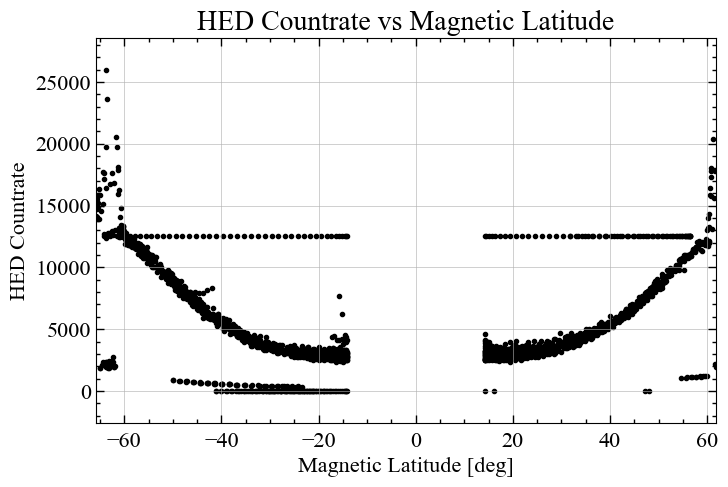

In [102]:
#plotting
#bad count rate @ 12,537. Systematic error for instrument?

plt.scatter(x=df['mlat'], y=df['cr'],marker='.',color='black')
plt.xlabel('Magnetic Latitude [deg]')
plt.ylabel('HED Countrate')
plt.title('HED Countrate vs Magnetic Latitude')
plt.grid()
plt.show()

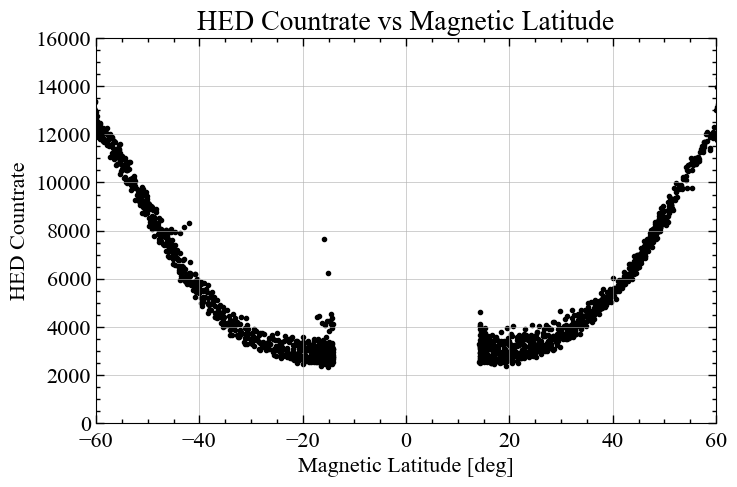

In [105]:
filtered_df = df.drop(df[(df['cr'] == 12537) | (df['cr'] < 2000)].index)

plt.scatter(x=filtered_df['mlat'], y=filtered_df['cr'],marker='.',color='black')
plt.xlabel('Magnetic Latitude [deg]')
plt.ylabel('HED Countrate')
plt.title('HED Countrate vs Magnetic Latitude')
plt.grid()

plt.ylim(0, 16000)
plt.xlim(-60,60)
plt.show()

In [109]:
#https://plotly.com/python/continuous-error-bars/

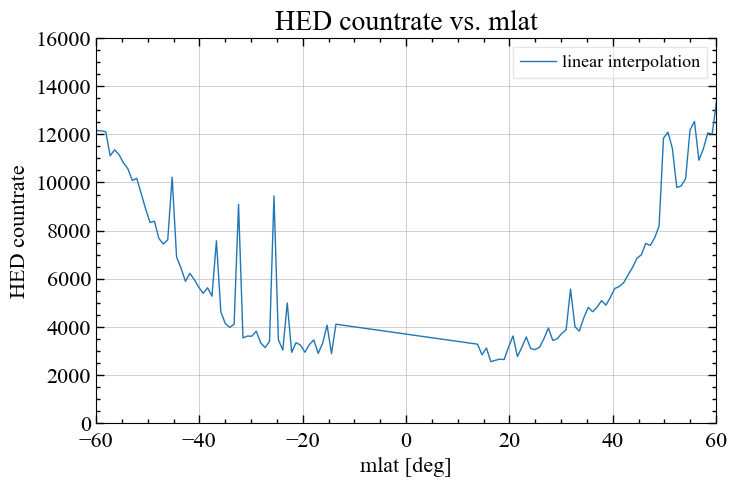

In [95]:
# Select data with hed_countrate greater than 2000
filtered_df = df[df['cr'] > 2000 and df['cr']>13000 ]

# Interpolate hed_countrate as a function of mlat
x = filtered_df['mlat']
y = filtered_df['cr']
f = interp1d(x, y,kind='linear')

# Generate evenly spaced values for mlat
x_new = np.linspace(x.min(), x.max(), num=150, endpoint=True)

# Evaluate the interpolated function at the new values for mlat
y_new = f(x_new)

# Plot the result
plt.plot(x_new, y_new,label='linear interpolation')

# Add grid and cap y-axis at 16000
plt.grid()
plt.ylim(0, 16000)
plt.xlim(-60,60)

# Add labels
plt.title('HED countrate vs. mlat')
plt.xlabel('mlat [deg]')
plt.ylabel('HED countrate')
plt.legend()
# Show plot
plt.show()

In [91]:
mlat = df['mlat'].to_numpy()

In [94]:
df.to_csv('/Home/siv30/wad005/master/GRB/MATLAB/david_sarria/df.csv',index=False)